### HRRR timeseries plots for InSAR

In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import cfgrib
import cf2cdm
from glob import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import xarray as xr
from datetime import datetime, timedelta
import urllib.request
from cfgrib.xarray_store import open_dataset
import warnings
import h5py

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy.interpolate import interp2d
from scipy.interpolate import griddata
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression

In [3]:
warnings.filterwarnings('ignore')

In [4]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [5]:
def remap_hrrr2SAR(hrrr_2dmap):
    "regrid hrrr data into SAR"
    
    lon_hrrr,lat_hrrr = np.meshgrid(pwat.longitude.values,pwat.latitude.values)
    lon_isar,lat_isar = np.meshgrid(lon_sar,lat_sar)
    points = np.stack([lon_hrrr.ravel(),lat_hrrr.ravel()]).swapaxes(0,1)
    var_remap = griddata(points, hrrr_2dmap.ravel(), (lon_isar, lat_isar), method='linear')
    
    return var_remap

In [6]:
def remap_hrrr2SAR_dbz(dbz_xr):
    "regrid hrrr data into SAR"
    
    lon_hrrr,lat_hrrr = np.meshgrid(pwat.longitude.values,pwat.latitude.values)
    lon_isar,lat_isar = np.meshgrid(lon_sar,lat_sar)
    points = np.stack([lon_hrrr.ravel(),lat_hrrr.ravel()]).swapaxes(0,1)
    var_remap = griddata(points, dbz_xr.values.ravel(), (lon_isar, lat_isar), method='linear')
    
    return var_remap

In [7]:
def remap_NCEPIR2SAR(BT_xr):
    "regrid hrrr data into SAR"
    
    lon_hrrr,lat_hrrr = np.meshgrid(BT_xr.longitude.values,BT_xr.latitude.values)
    lon_isar,lat_isar = np.meshgrid(lon_sar,lat_sar)
    points = np.stack([lon_hrrr.ravel(),lat_hrrr.ravel()]).swapaxes(0,1)
    var_remap = griddata(points, BT_xr.values.ravel(), (lon_isar, lat_isar), method='linear')
    
    return var_remap

In [8]:
# get geolocation from InSAR
geo_file = '/data2/willytsai/InSAR_HRRR/CentralNevadaSenAT166/mintpy/inputs/geometryRadar.h5'
geo = h5py.File(geo_file,'r')
# for key in geo.keys():
#     print(key) #Names of the groups in HDF5 file.
lat = geo['latitude'];
lon = geo['longitude'];
incidence = geo['incidenceAngle'];
axis_bound = [np.min(lat),np.max(lat),np.min(lon),np.max(lon)]; # coordinate bound [South,North,West,East]
axis_bound = [np.unique(lat.value)[1],np.unique(lat.value)[-1],np.unique(lon.value)[0],np.unique(lon.value)[-2]]
axis_bound

[37.228, 43.223568, -119.00549, -114.65358]

In [6]:
# merge
os.chdir('/data2/willytsai/InSAR_HRRR/HRRR_data/t02z/regrid_3km/')

In [7]:
# load merged HRRR regridded 3km data 
data = xr.open_dataset('/data2/willytsai/InSAR_HRRR/HRRR_data/t02z/merged/HRRR_pwat_NEVADA.nc')
pwat = data.pwat
date = data.time

data = xr.open_dataset('/data2/willytsai/InSAR_HRRR/HRRR_data/t02z/merged/HRRR_Psfc_NEVADA.nc')
ps = data.ps

In [8]:
# reference date
date_ref = np.loadtxt('/data2/willytsai/InSAR_HRRR/CentralNevadaSenAT166/mintpy/pic/reference_date.txt')
print(date_ref)

20171007.0


In [9]:
# load elevation map
topo_sar = xr.open_dataset('/data2/willytsai/InSAR_HRRR/HRRR_data/elevation_NEVADA_sar.nc')
topo_hrrr = xr.open_dataset('/data2/willytsai/InSAR_HRRR/HRRR_data/elevation_NEVADA_hrrr.nc')

In [10]:
# data = np.loadtxt('/data2/willytsai/InSAR_HRRR/HRRR_data/output_srtm.asc',skiprows=6)
# data = np.flipud(data) # flip into ascending lat
# lon_topo = np.linspace(-120,-114,7200)
# lat_topo = np.linspace(36,44,9600)

In [11]:
# constructing corresponding pwat_diff 
pwat_acqu = pwat[:,:,:]
date_acqu = date[:].values
ps_acqu = ps[:,:,:]
idx_ref = np.where(date_acqu == np.datetime64(datetime.strptime(str(date_ref)[:-2]+'02','%Y%m%d%H')))[0][0]
print(date_acqu[idx_ref])

2017-10-07T02:00:00.000000000


In [12]:
# subplots setup rows and cols
rows,remainder = np.divmod(len(date_acqu),21)
row = np.repeat(np.arange(0,rows+1),21)
col = np.tile(np.arange(0,21),rows+1)

In [13]:
# %%time
# # plotting pwat_diff timeseries
# fig,ax = plt.subplots(rows+1,21,figsize=(30,15))
# for t in range(len(col)):
#     try:
#         cf = ax[row[t],col[t]].pcolor(pwat.longitude,pwat.latitude,pwat_acqu[idx_ref,:,:]-pwat_acqu[t,:,:]
#                                       ,cmap='jet',vmin=-16,vmax=16)
#         ax[row[t],col[t]].set_ylim([axis_bound[0], axis_bound[1]])
#         ax[row[t],col[t]].set_xlim([axis_bound[2], axis_bound[3]])
#         ax[row[t],col[t]].set_title(str(date_acqu[t])[:10],fontsize=12)
#         ax[row[t],col[t]].set_xticks([]);ax[row[t],col[t]].set_yticks([])
#         ax[row[t],col[t]].spines['bottom'].set_color('w')
#         ax[row[t],col[t]].spines['top'].set_color('w') 
#         ax[row[t],col[t]].spines['right'].set_color('w')
#         ax[row[t],col[t]].spines['left'].set_color('w')
    
#     except:
#         ax[row[t],col[t]].set_xticks([]);ax[row[t],col[t]].set_yticks([])
#         ax[row[t],col[t]].spines['bottom'].set_color('w')
#         ax[row[t],col[t]].spines['top'].set_color('w') 
#         ax[row[t],col[t]].spines['right'].set_color('w')
#         ax[row[t],col[t]].spines['left'].set_color('w')
        
#     if t == len(date_acqu)-1:
#         cbaxes = inset_axes(ax[row[t],col[t]], width="20%",height="100%",loc='lower left',
#            bbox_to_anchor=(1.2, 0., 1, 1),bbox_transform=ax[row[t],col[t]].transAxes,
#            borderpad=0) 
#         cbar=fig.colorbar(cf,cax=cbaxes,ticks=[-15,-10,-5,0,5,10,15],orientation='vertical')
#         cbar.set_label('$\Delta$PW [mm]')
    
    
#     if t < pwat_acqu.shape[0] and np.isnan(pwat_acqu[t,0,0].values) == 0:
#         # swath sketch by eyeballing
#         y1 = np.array([axis_bound[0],43])
#         x1 = np.array([-117.5,axis_bound[2]])
#         y2 = np.array([37.5,axis_bound[1]])
#         x2 = np.array([axis_bound[3],-115.85])
#         ax[row[t],col[t]].plot(x1,y1,'k',linewidth=1)
#         ax[row[t],col[t]].plot(x2,y2,'k',linewidth=1)
#         ax[row[t],col[t]].plot(x1,y1,'k',linewidth=1)
#         ax[row[t],col[t]].plot(x2,y2,'k',linewidth=1)

# fig.patch.set_facecolor('white')

In [14]:
# fig.savefig('HRRR3km_timeseries_new.png',bbox_inches='tight',dpi=300)

### 1. Get InSAR data at each acquisition 

In [9]:
data_ifgrams = h5py.File('/data2/willytsai/InSAR_HRRR/CentralNevadaSenAT166/mintpy/S1_IW123_166_0121_0140_20150322_XXXXXXXX.he5', 'r')
list(data_ifgrams.keys())

['HDFEOS']

In [10]:
geo_info = data_ifgrams['HDFEOS']['GRIDS']['timeseries']['geometry']
ifgrams = data_ifgrams['HDFEOS']['GRIDS']['timeseries']['observation']

In [11]:
print(list(geo.keys()))
print(list(ifgrams.keys()))

['azimuthAngle', 'height', 'incidenceAngle', 'latitude', 'longitude', 'shadowMask', 'slantRangeDistance']
['bperp', 'date', 'displacement']


In [12]:
inc_angle = geo_info['incidenceAngle']
disp_0 = ifgrams['displacement']
lon_ifgrams = geo_info['longitude']
lat_ifgrams = geo_info['latitude']
shadowMask = geo_info['shadowMask']
date_ifgrams = ifgrams['date']
height =  geo_info['height']

In [46]:
ifgrams['displacement']['Units']

ValueError: Field names only allowed for compound types

TypeError: 'DimensionManager' object is not callable

In [14]:
# flipping disp for ascending lat
disp = np.zeros(disp_0.shape)
for t in range(len(date_ifgrams)):
    disp[t,:,:] = -np.flipud(disp_0[t,:,:]) # delay singal [m]

In [15]:
axis_bound

[37.228, 43.223568, -119.00549, -114.65358]

In [16]:
lon_sar = np.linspace(axis_bound[2],axis_bound[3],lon_ifgrams.shape[1])
lat_sar = np.linspace(axis_bound[0],axis_bound[1],lon_ifgrams.shape[0])

In [23]:
# #write insar into netcdf
# disp_acqu_xr = xr.DataArray(disp*np.flipud(np.cos(inc_angle.value/180*np.pi)),dims=('time','latitude','longitude')
#                             ,coords=(date,lat_sar,lon_sar),name='displacement')
# disp_acqu_ds = disp_acqu_xr.to_dataset(name='disp_zenith')
# disp_acqu_ds.to_netcdf('/data2/willytsai/InSAR_HRRR/HRRR_data/t02z/merged/InSAR_zenithdisp_NEVADA.nc')

In [24]:
# %%time
# # plotting pwat_diff timeseries
# fig,ax = plt.subplots(rows+1,21,figsize=(30,15))
# for t in range(len(col)):
#     try:
#         cf = ax[row[t],col[t]].pcolor(lon_sar,lat_sar,disp[t,:,:]
#                                       ,cmap='jet',vmin=-16,vmax=16)
#         ax[row[t],col[t]].set_ylim([axis_bound[0], axis_bound[1]])
#         ax[row[t],col[t]].set_xlim([axis_bound[2], axis_bound[3]])
#         ax[row[t],col[t]].set_title(str(date_acqu[t])[:10],fontsize=12)
#         ax[row[t],col[t]].set_xticks([]);ax[row[t],col[t]].set_yticks([])
#         ax[row[t],col[t]].spines['bottom'].set_color('w')
#         ax[row[t],col[t]].spines['top'].set_color('w') 
#         ax[row[t],col[t]].spines['right'].set_color('w')
#         ax[row[t],col[t]].spines['left'].set_color('w')
    
#     except:
#         ax[row[t],col[t]].set_xticks([]);ax[row[t],col[t]].set_yticks([])
#         ax[row[t],col[t]].spines['bottom'].set_color('w')
#         ax[row[t],col[t]].spines['top'].set_color('w') 
#         ax[row[t],col[t]].spines['right'].set_color('w')
#         ax[row[t],col[t]].spines['left'].set_color('w')
        
#     if t == len(date_acqu)-1:
#         cbaxes = inset_axes(ax[row[t],col[t]], width="20%",height="100%",loc='lower left',
#            bbox_to_anchor=(1.2, 0., 1, 1),bbox_transform=ax[row[t],col[t]].transAxes,
#            borderpad=0) 
#         cbar=fig.colorbar(cf,cax=cbaxes,ticks=[-15,-10,-5,0,5,10,15],orientation='vertical')
#         cbar.set_label('$\Delta$PW [mm]')
    
    
#     if t < pwat_acqu.shape[0] and np.isnan(pwat_acqu[t,0,0].values) == 0:
#         # swath sketch by eyeballing
#         y1 = np.array([axis_bound[0],43])
#         x1 = np.array([-117.5,axis_bound[2]])
#         y2 = np.array([37.5,axis_bound[1]])
#         x2 = np.array([axis_bound[3],-115.85])
#         ax[row[t],col[t]].plot(x1,y1,'k',linewidth=1)
#         ax[row[t],col[t]].plot(x2,y2,'k',linewidth=1)
#         ax[row[t],col[t]].plot(x1,y1,'k',linewidth=1)
#         ax[row[t],col[t]].plot(x2,y2,'k',linewidth=1)

# fig.patch.set_facecolor('white')

In [25]:
# for t in range(len(date_ifgrams)):
#     fig,ax = plt.subplots(1,3,figsize=(15,8))

#     cf1 = ax[0].contourf(lon_sar,lat_sar,disp[t,:,:]*100,levels=np.linspace(-20,20,21),cmap='jet')
#     ax[0].set_title('InSAR_disp, '+str(date_ifgrams[t])[2:-1],fontsize=14);
#     ax[0].set_xlabel('Longitude',fontsize=14);ax[0].set_ylabel('Latitude',fontsize=14)
#     cbar1 = plt.colorbar(cf1,ax=ax[0],orientation='horizontal',pad=0.1,shrink=0.7)
#     cbar1.set_label('[cm]',fontsize=13)

#     cf2 = ax[1].contourf(pwat.longitude,pwat.latitude,pwat_acqu[idx_ref,:,:]-pwat_acqu[t,:,:],
#                         levels=21,cmap='jet')
#     ax[1].set_title('HRRR, '+str(date_ifgrams[t])[2:-1],fontsize=14)
#     ax[1].set_xlabel('Longitude',fontsize=14);ax[1].set_ylabel('Latitude',fontsize=14)
#     cbar2 = plt.colorbar(cf2,ax=ax[1],orientation='horizontal',pad=0.1,shrink=0.7)
#     cbar2.set_label('[mm]',fontsize=13)

#     cf3 = ax[2].contourf(pwat.longitude,pwat.latitude,1/6*(pwat_acqu[idx_ref,:,:]-pwat_acqu[t,:,:]),
#                         levels=np.linspace(-5,5,21),cmap='jet')
#     ax[2].set_xlabel('Longitude',fontsize=14);ax[2].set_ylabel('Latitude',fontsize=14)
#     cbar3 = plt.colorbar(cf3,ax=ax[2],orientation='horizontal',pad=0.1,shrink=0.7)
#     cbar3.set_label('[mm]*6',fontsize=13)

#     ax[1].set_ylim([axis_bound[0], axis_bound[1]])
#     ax[1].set_xlim([axis_bound[2], axis_bound[3]])
#     ax[2].set_ylim([axis_bound[0], axis_bound[1]])
#     ax[2].set_xlim([axis_bound[2], axis_bound[3]])

#     # swath sketch by eyeballing
#     y1 = np.array([axis_bound[0],43])
#     x1 = np.array([-117.5,axis_bound[2]])
#     y2 = np.array([37.5,axis_bound[1]])
#     x2 = np.array([axis_bound[3],-115.85])
#     ax[1].plot(x1,y1,'k',linewidth=1)
#     ax[1].plot(x2,y2,'k',linewidth=1)
#     ax[2].plot(x1,y1,'k',linewidth=1)
#     ax[2].plot(x2,y2,'k',linewidth=1)
#     #plt.ylim(axis_bound[0],axis_bound[1])

#     fig.savefig('/data2/willytsai/InSAR_HRRR/HRRR_data/t02z/HRRR_InSAR_'+str(date_ifgrams[t])[2:-1]+'.png',dpi=300,bbox_inches='tight')
    
#     plt.close()

### 2. Statistical analysis

In [26]:
fig_dir = '/data2/willytsai/InSAR_HRRR/HRRR_data/t02z/fig/'

In [27]:
# extract HRRR grids corresponding to available grids in InSAR
disp_tmp = np.copy(disp[0,:,:])
disp_tmp[np.abs(disp_tmp)>=0] = 1
sar_mask = np.copy(disp_tmp) # HRRR mask [0,1]
idx_inc = np.where(sar_mask.ravel()>0) # valid index
topo_sar_mask = np.copy(np.flipud(topo_sar.elevation))
tmp = np.zeros(disp_tmp.shape[0]*disp_tmp.shape[1])*np.nan
tmp[idx_inc] = (np.flipud(topo_sar.elevation)).ravel()[idx_inc]
topo_sar_mask[:,:] = np.reshape(tmp,(disp.shape[1],disp.shape[2]))

# HRRR_mask corresponding to InSAR area
lon_hrrr,lat_hrrr = np.meshgrid(pwat.longitude.values,pwat.latitude.values)
lon_isar,lat_isar = np.meshgrid(lon_sar,lat_sar)
points = np.stack([lon_isar.ravel(),lat_isar.ravel()]).swapaxes(0,1)
disp_remap = griddata(points, disp[-1,:,:].ravel(), (lon_hrrr, lat_hrrr), method='nearest')

disp_remap[np.abs(disp_remap)>=0] = 1
HRRR_mask = np.copy(disp_remap) # HRRR mask [0,1]
idx_inc = np.where(HRRR_mask.ravel()>0) # valid index
topo_hrrr_mask = np.copy(topo_hrrr.elevation)
tmp = np.zeros(disp_remap.shape[0]*disp_remap.shape[1])*np.nan
tmp[idx_inc] = (topo_hrrr.elevation).values.ravel()[idx_inc]
topo_hrrr_mask[:,:] = np.reshape(tmp,(disp_remap.shape[0],disp_remap.shape[1]))

# ==== vars_diff for ps and pwat =======
pwat_diff = np.copy(pwat_acqu) # PW_diff array 
ps_diff = np.copy(ps_acqu) # Psfc_diff array
for t in range(len(date_ifgrams)):
    tmp = np.zeros(pwat_acqu.shape[1]*pwat_acqu.shape[2])*np.nan
    tmp[idx_inc] = (pwat_acqu[t,:,:]-pwat_acqu[idx_ref,:,:]).values.ravel()[idx_inc]
    pwat_diff[t,:,:] = np.reshape(tmp,(pwat_acqu.shape[1],pwat_acqu.shape[2]))
    
    tmp = np.zeros(ps_acqu.shape[1]*ps_acqu.shape[2])*np.nan
    tmp[idx_inc] = (ps_acqu[t,:,:]-ps_acqu[idx_ref,:,:]).values.ravel()[idx_inc]
    ps_diff[t,:,:] = np.reshape(tmp,(ps_acqu.shape[1],ps_acqu.shape[2]))

In [28]:
# # write pwat_diff into netcdf
# pw_diff_xr = xr.DataArray(pwat_diff,dims=('time','latitude','longitude')
#                             ,coords=(date,pwat.latitude,pwat.longitude),name='pwat')
# pw_diff_ds = pw_diff_xr.to_dataset(name='pwat')
# pw_diff_ds.to_netcdf('/data2/willytsai/InSAR_HRRR/HRRR_data/t02z/merged/HRRR_PW_diff_NEVADA.nc')

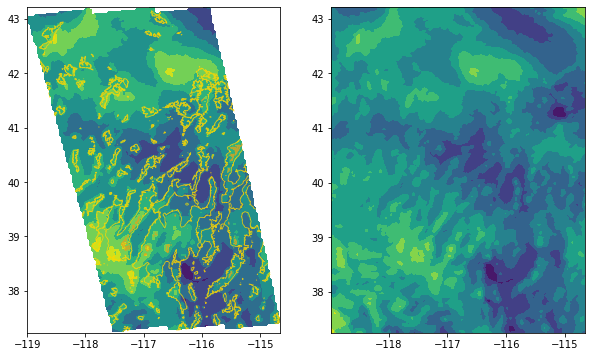

In [29]:
fig,ax = plt.subplots(1,2,figsize=(10,6))
ax[0].contourf(pwat.longitude, pwat.latitude, pwat_diff[-1,:,:])
ax[0].contour(lon_sar,lat_sar,topo_sar_mask,levels=[2000,3000,4000]
              ,colors=['gold','goldenrod','darkgoldenrod'],linewidths=0.8,alpha=0.8)
ax[1].contourf(pwat.longitude, pwat.latitude, pwat_acqu[-1,:,:]-pwat_acqu[idx_ref,:,:])

In [30]:
# find out offset in InSAR to match the same area-averaged value
factor_invert = 1/6 # transfer InSAR signal comparable to HRRR PW_diff: 1mm PW --> 6mm delay
factor_zenith = np.flipud(np.cos(inc_angle.value/180*np.pi)) # times np.cos(incidence angle) to zenith direction

pw_diff_mean = np.nanmean(pwat_diff,axis=(1,2)) # [mm]
disp_zenith = disp*factor_zenith*100*10 #[mm] zenith displacement 

# formulation: [6*pw_diff]_xy = [insar*cos(inc_ang)]_xy + [offset*cos(inc_ang)]_xy
disp_zenith_mean = np.nanmean(disp_zenith,axis=(1,2))
disp_offset = (pw_diff_mean/factor_invert - disp_zenith_mean)/np.nanmean(factor_zenith) # estimated offset of zenith signal

In [31]:
np.nanmean(disp[0,:,:],axis=(0,1))

-0.01921728985213274

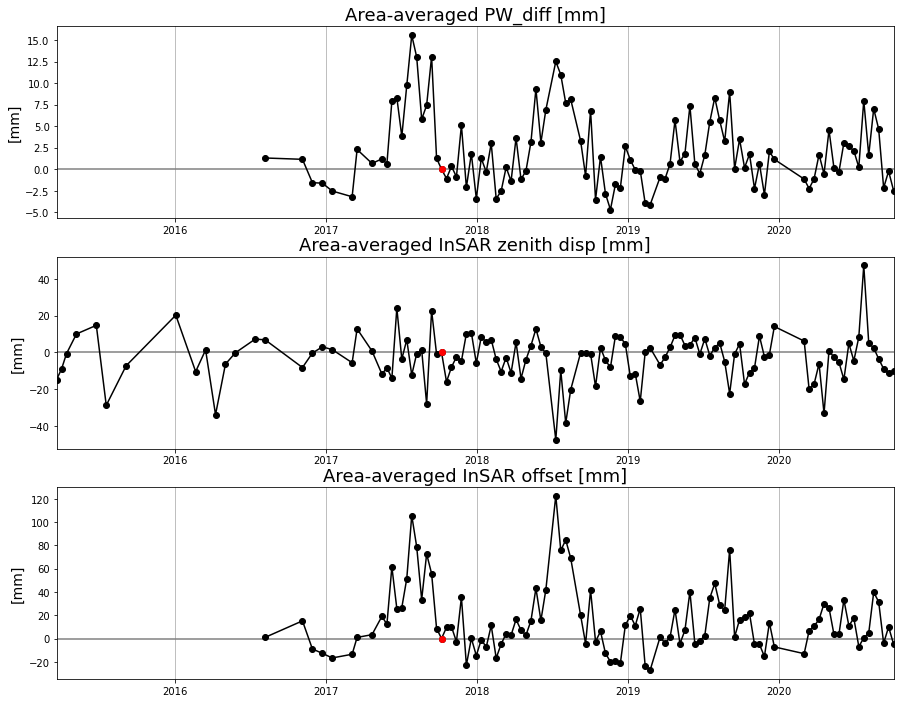

In [32]:
fig,ax = plt.subplots(3,1,figsize=(15,12))
ax[0].plot(date_acqu,pw_diff_mean,'-ok')
ax[0].hlines(y=0,xmin=date_acqu[0],xmax=date_acqu[-1],color='grey')
ax[0].set_xlim([date_acqu[0],date_acqu[-1]])
ax[0].set_title('Area-averaged PW_diff [mm]',fontsize=18)
ax[0].set_ylabel('[mm]',fontsize=14)

ax[0].plot(date_acqu[idx_ref],pw_diff_mean[idx_ref],'or')
ax[0].grid(axis='x')

ax[1].plot(date_acqu,disp_zenith_mean,'-ok')
ax[1].hlines(y=0,xmin=date_acqu[0],xmax=date_acqu[-1],color='grey')
ax[1].set_xlim([date_acqu[0],date_acqu[-1]])
ax[1].set_title('Area-averaged InSAR zenith disp [mm]',fontsize=18)
ax[1].set_ylabel('[mm]',fontsize=14)

ax[1].plot(date_acqu[idx_ref],disp_zenith_mean[idx_ref],'or')
ax[1].grid(axis='x')

ax[2].plot(date_acqu,disp_offset*np.nanmean(factor_zenith),'-ok')
ax[2].hlines(y=0,xmin=date_acqu[0],xmax=date_acqu[-1],color='grey')
ax[2].set_xlim([date_acqu[0],date_acqu[-1]])
ax[2].set_title('Area-averaged InSAR offset [mm]',fontsize=18)
ax[2].set_ylabel('[mm]',fontsize=14)

ax[2].plot(date_acqu[idx_ref],disp_zenith_mean[idx_ref],'or')
ax[2].grid(axis='x')

#fig.savefig(fig_dir+'InSAR_offset_timeseries.png',dpi=300,box_inches='tight')

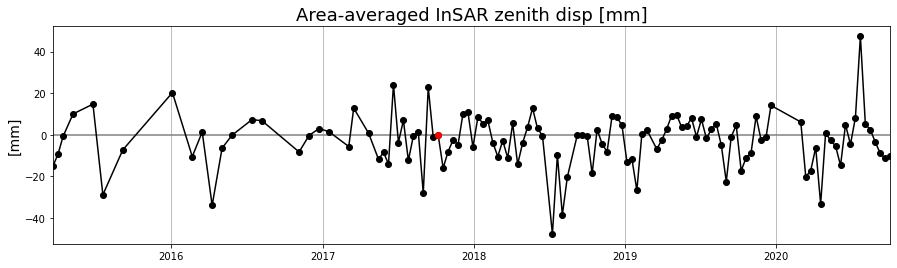

In [33]:
fig = plt.figure(figsize=(15,4))
plt.plot(date_acqu,disp_zenith_mean,'-ok')
plt.hlines(y=0,xmin=date_acqu[0],xmax=date_acqu[-1],color='grey')
plt.xlim([date_acqu[0],date_acqu[-1]])
plt.title('Area-averaged InSAR zenith disp [mm]',fontsize=18)
plt.ylabel('[mm]',fontsize=14)

plt.plot(date_acqu[idx_ref],disp_zenith_mean[idx_ref],'or')
plt.grid(axis='x')

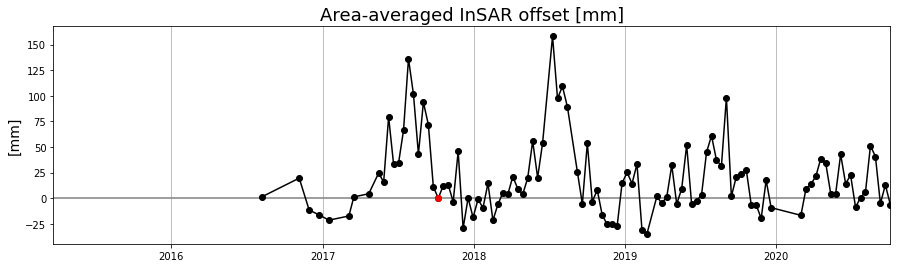

In [34]:
fig = plt.figure(figsize=(15,4))
plt.plot(date_acqu,disp_offset,'-ok')
plt.hlines(y=0,xmin=date_acqu[0],xmax=date_acqu[-1],color='grey')
plt.xlim([date_acqu[0],date_acqu[-1]])
plt.title('Area-averaged InSAR offset [mm]',fontsize=18)
plt.ylabel('[mm]',fontsize=14)

plt.plot(date_acqu[idx_ref],disp_zenith_mean[idx_ref],'or')
plt.grid(axis='x')

In [35]:
# rebuild disp array by adding offsets
disp_rebuild = np.copy(disp)
for t in range(len(date_ifgrams)):
    disp_rebuild[t,:,:] = (disp[t,:,:]*100*10 + np.ones(disp[t,:,:].shape)*disp_offset[t])

disp_zenith_re = disp_rebuild*factor_zenith # new zenith disp array with offset added [mm]

Text(0, 0.5, '[mm]')

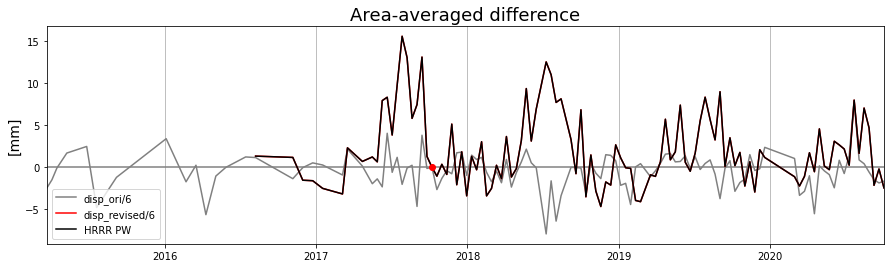

In [36]:
fig = plt.figure(figsize=(15,4))

plt.plot(date_acqu,np.nanmean(disp_zenith/6,axis=(1,2)),color='grey')
plt.plot(date_acqu,np.nanmean(disp_zenith_re/6,axis=(1,2)),'r')
plt.plot(date_acqu,np.nanmean(pwat_diff,axis=(1,2)),'k')

plt.plot(date_acqu[idx_ref],disp_zenith_mean[idx_ref],'or')
plt.hlines(y=0,xmin=date_acqu[0],xmax=date_acqu[-1],color='grey')
plt.grid(axis='x')
plt.legend(['disp_ori/6','disp_revised/6','HRRR PW'],loc=3)
plt.xlim([date_acqu[0],date_acqu[-1]])
plt.title('Area-averaged difference',fontsize=18)
plt.ylabel('[mm]',fontsize=14)

Text(-118.4, 44.1, '2020-10-03')

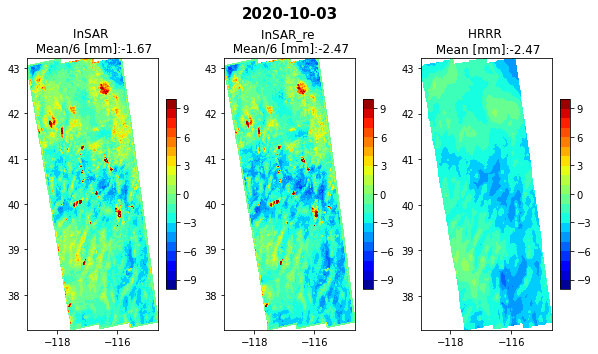

In [37]:
fig,ax = plt.subplots(1,3,figsize=(10,5))
cf0 = ax[0].contourf(lon_sar, lat_sar, disp_zenith[-1,:,:]/6,levels=np.linspace(-10,10,21)
                    ,cmap='jet')
plt.colorbar(cf0,ax=ax[0],shrink=0.7)
ax[0].set_title('InSAR \n Mean/6 [mm]:'+str(round(np.nanmean(disp_zenith[-1,:,:]/6),2)))

cf1 = ax[1].contourf(lon_sar, lat_sar, disp_zenith_re[-1,:,:]/6,levels=np.linspace(-10,10,21)
                    ,cmap='jet')
plt.colorbar(cf1,ax=ax[1],shrink=0.7)
ax[1].set_title('InSAR_re \n Mean/6 [mm]:'+str(round(np.nanmean(disp_zenith_re[-1,:,:]/6),2)))

cf2 = ax[2].contourf(pwat.longitude, pwat.latitude, pwat_diff[-1,:,:],levels=np.linspace(-10,10,21)
                    ,cmap='jet')
cbar = plt.colorbar(cf2,ax=ax[2],shrink=0.7)
ax[2].set_title('HRRR \n Mean [mm]:'+str(round(np.nanmean(pwat_diff[-1,:,:]),2)));
ax[1].text(-118.4,44.1,str(date_acqu[-1])[:10],fontsize=15,fontweight='bold')

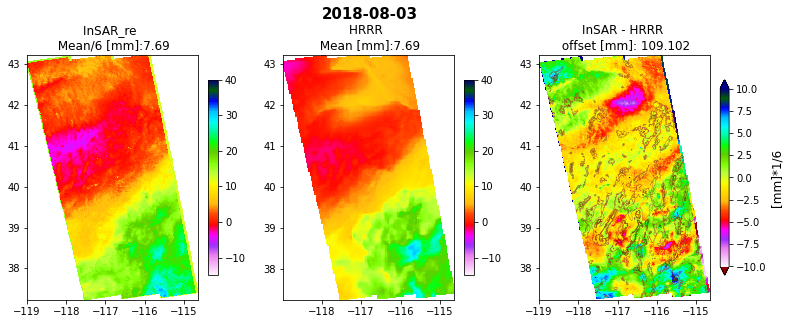

In [38]:
t=58

fig,ax = plt.subplots(1,3,figsize=(13,4.5))

a = disp_zenith_re[t,:,:]/6
clevels = np.linspace(-15,40,26)

cf1 = ax[0].pcolor(lon_sar, lat_sar, disp_zenith_re[t,:,:]/6
                     ,vmin=-15,vmax=40,cmap='gist_ncar_r')
ax[0].set_title('InSAR_re \n Mean/6 [mm]:'+str(round(np.nanmean(disp_zenith_re[t,:,:]/6),2)))
cbar1 = plt.colorbar(cf1,ax=ax[0],shrink=0.8)
cbar1.cmap.set_under('darkred')
cbar1.cmap.set_over('darkblue')

cf2 = ax[1].pcolor(pwat.longitude, pwat.latitude, pwat_diff[t,:,:],vmin=-15,vmax=40
                    ,cmap='gist_ncar_r')
ax[1].set_title('HRRR \n Mean [mm]:'+str(round(np.nanmean(pwat_diff[t,:,:]),2)));
ax[1].text(-118,44.1,str(date_acqu[t])[:10],fontsize=15,fontweight='bold')
cbar2 = plt.colorbar(cf2,ax=ax[1],shrink=0.8)
cbar2.cmap.set_under('darkred')
cbar2.cmap.set_over('darkblue')

# diff between HRRR and SAR
hrrr_pw = remap_hrrr2SAR(pwat_diff[t,:,:])
cf3 = ax[2].pcolor(lon_sar,lat_sar,disp_zenith_re[t,:,:]/6-hrrr_pw,vmin=-10,vmax=10
                     ,cmap='gist_ncar_r')
ax[2].set_title('InSAR - HRRR \n offset [mm]: '+str(np.round(disp_offset[t],4)))
ax[2].contour(lon_sar,lat_sar,topo_sar_mask,levels=['2000','2500'],colors=['brown','maroon'],linewidths=0.5,alpha=0.6)

cbar3 = plt.colorbar(cf3,ax=ax[2],extend='both',shrink=0.8)
cbar3.set_label('[mm]*1/6',fontsize=12)
cbar3.cmap.set_under('darkred')
cbar3.cmap.set_over('darkblue')

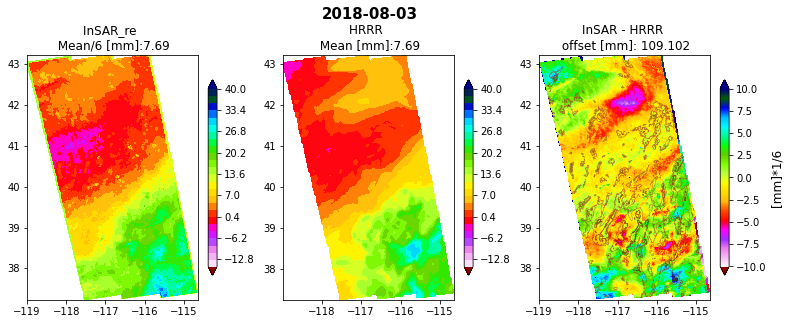

In [39]:
t=58

fig,ax = plt.subplots(1,3,figsize=(13,4.5))

a = disp_zenith_re[t,:,:]/6
clevels = np.linspace(-15,40,26)

cf1 = ax[0].contourf(lon_sar, lat_sar, disp_zenith_re[t,:,:]/6
                     ,levels=clevels,cmap='gist_ncar_r',extend='both')
ax[0].set_title('InSAR_re \n Mean/6 [mm]:'+str(round(np.nanmean(disp_zenith_re[t,:,:]/6),2)))
cbar1 = plt.colorbar(cf1,ax=ax[0],shrink=0.8)
cbar1.cmap.set_under('darkred')
cbar1.cmap.set_over('darkblue')

cf2 = ax[1].contourf(pwat.longitude, pwat.latitude, pwat_diff[t,:,:],levels=clevels
                    ,cmap='gist_ncar_r',extend='both')
ax[1].set_title('HRRR \n Mean [mm]:'+str(round(np.nanmean(pwat_diff[t,:,:]),2)));
ax[1].text(-118,44.1,str(date_acqu[t])[:10],fontsize=15,fontweight='bold')
cbar2 = plt.colorbar(cf2,ax=ax[1],shrink=0.8)
cbar2.cmap.set_under('darkred')
cbar2.cmap.set_over('darkblue')

# diff between HRRR and SAR
hrrr_pw = remap_hrrr2SAR(pwat_diff[t,:,:])
cf3 = ax[2].pcolor(lon_sar,lat_sar,disp_zenith_re[t,:,:]/6-hrrr_pw,vmin=-10,vmax=10
                     ,cmap='gist_ncar_r')
ax[2].set_title('InSAR - HRRR \n offset [mm]: '+str(np.round(disp_offset[t],4)))
ax[2].contour(lon_sar,lat_sar,topo_sar_mask,levels=['2000','2500'],colors=['brown','maroon'],linewidths=0.5,alpha=0.6)

cbar3 = plt.colorbar(cf3,ax=ax[2],extend='both',shrink=0.8)
cbar3.set_label('[mm]*1/6',fontsize=12)
cbar3.cmap.set_under('darkred')
cbar3.cmap.set_over('darkblue')

### Reconstruct PW time-series at the reference point
- PW_abs(t1) = PW_abs(t_ref) + delta_PW(t1-t_ref) 
- Expand from a single reference point to 2d map

reference point: 735 400
check reference point: disp -0.0


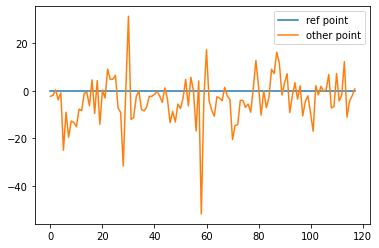

In [40]:
# reference point (lon,lat)
idx = find_nearest(lon_sar,-117.168465)
idy = find_nearest(lat_sar,38.228363)
hydro_factor = 1e-6*0.776*287.15/9.8 # [m/pa]
print('reference point:',idx,idy)
print('check reference point: disp',disp_zenith[90,idy,idx])
plt.plot(disp_zenith[:,idy,idx],label='reference')
plt.plot(disp_zenith[:,600,600],label='other')
plt.legend(['ref point','other point'])

In [41]:
t= 58

sar_ps_diff = remap_hrrr2SAR(ps_diff[t,:,:]) # regrid pressure diff into sar grid
sar_pwat_abs_ref = remap_hrrr2SAR(pwat_acqu[idx_ref,:,:].values)[idy,idx] # PW abs value at reference time and point
sar_dry_delay = hydro_factor*sar_ps_diff*1000 #[mm]
pwat_abs = remap_hrrr2SAR(pwat_acqu[t,:,:].values)

# reconstructing 2D-map
pwat_re = sar_pwat_abs_ref + (disp_zenith[t,:,:]-sar_dry_delay)/6

(array([ 15893.,  51816., 278519., 400394., 639622., 537239., 468085.,
        320414.,  93751.,   5202.]),
 array([-16.57961247, -14.42466507, -12.26971767, -10.11477027,
         -7.95982287,  -5.80487547,  -3.64992806,  -1.49498066,
          0.65996674,   2.81491414,   4.96986154]),
 <BarContainer object of 10 artists>)

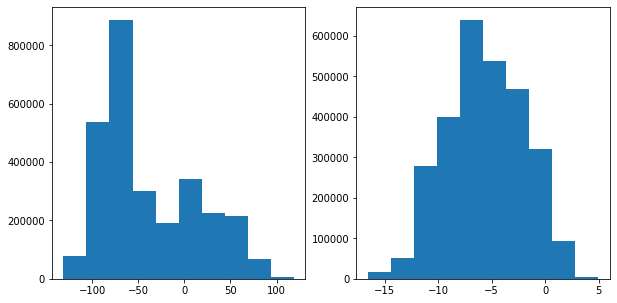

In [42]:
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].hist(disp_zenith[t,:,:].ravel())
ax[1].hist(sar_dry_delay.ravel())

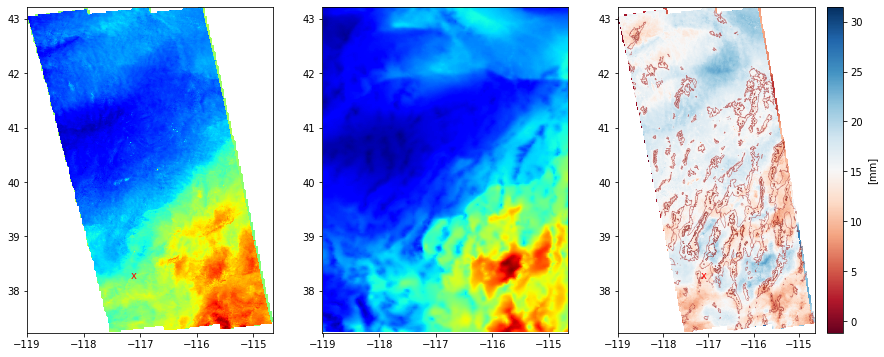

In [43]:
fig,ax = plt.subplots(1,3,figsize=(15,6))

ax[0].pcolor(lon_sar,lat_sar,pwat_re,cmap='jet')
ax[1].pcolor(lon_sar,lat_sar,pwat_abs,cmap='jet')
ax[0].text(lon_sar[idx],lat_sar[idy],'x',color='red')

cf3 = ax[2].pcolor(lon_sar,lat_sar,pwat_abs-pwat_re,cmap='RdBu')
ax[2].contour(lon_sar,lat_sar,topo_sar_mask,levels=['2000','2500']
             ,colors=['brown','maroon'],linewidths=0.5,alpha=0.6)
ax[2].text(lon_sar[idx],lat_sar[idy],'x',color='red')

cbar = plt.colorbar(cf3,ax=ax[2]);cbar.set_label('[mm]')

In [44]:
# load IR data
Tb_acqu = xr.open_dataarray('/data2/willytsai/InSAR_HRRR/NCEP_CPC_IRmerge/NCEP_CPC_Tb_NEVADA.nc')

# load maximum reflectivity 
# merge HRRR dataset 
os.chdir('/data2/willytsai/InSAR_HRRR/HRRR_data/t02z/prs_levels/regrid_3km')
tmp = xr.open_dataset('hrrr.20180803.t02z.regrid3km.grib2',engine='cfgrib',backend_kwargs=dict(filter_by_keys={'typeOfLevel': 'atmosphere'}))

In [64]:
axis_bound

[37.228, 43.223568, -119.00549, -114.65358]

In [77]:
tmp_NEVADA = tmp.sel(longitude=slice(axis_bound[2]+360,axis_bound[3]+360)
                    ,latitude=slice(axis_bound[0],axis_bound[1]))

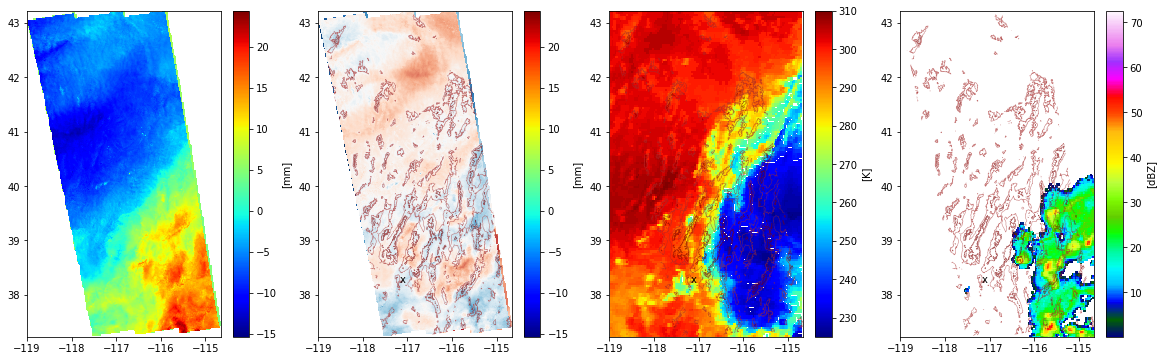

In [45]:
# assuming the reconstruct mean should be the same...
adjust_mean = np.nanmean(pwat_abs)-np.nanmean(pwat_re)

fig,ax = plt.subplots(1,4,figsize=(20,6))

cf1 = ax[0].pcolor(lon_sar,lat_sar,pwat_re,cmap='jet')
cbar1 = plt.colorbar(cf1,ax=ax[0]);cbar1.set_label('[mm]')

cf2 = ax[1].pcolor(lon_sar,lat_sar,pwat_re-pwat_abs+adjust_mean,cmap='RdBu')
ax[1].contour(lon_sar,lat_sar,topo_sar_mask,levels=['2000','2500']
             ,colors=['brown','maroon'],linewidths=0.5,alpha=0.6)
ax[1].text(lon_sar[idx],lat_sar[idy],'x',color='k')
cbar2 = plt.colorbar(cf1,ax=ax[1]);cbar2.set_label('[mm]')

cf3 = ax[2].pcolor(Tb_acqu.longitude,Tb_acqu.latitude,Tb_acqu[t,:,:],cmap='jet')
ax[2].contour(lon_sar,lat_sar,topo_sar_mask,levels=['2000','2500']
             ,colors=['brown','maroon'],linewidths=0.5,alpha=0.6)
ax[2].text(lon_sar[idx],lat_sar[idy],'x',color='k')
cbar3 = plt.colorbar(cf3,ax=ax[2]);cbar3.set_label('[K]')

refc = tmp.refc.values
refc[refc<=0] = np.nan
cf4 = ax[3].pcolor(tmp.longitude-360,tmp.latitude,refc,cmap='gist_ncar')
ax[3].set_ylim([axis_bound[0],axis_bound[1]]);ax[3].set_xlim([axis_bound[2],axis_bound[3]])
ax[3].contour(lon_sar,lat_sar,topo_sar_mask,levels=['2000','2500']
             ,colors=['brown','maroon'],linewidths=0.5,alpha=0.6)
ax[3].text(lon_sar[idx],lat_sar[idy],'x',color='k')
cbar4 = plt.colorbar(cf4,ax=ax[3]);cbar4.set_label('[dBZ]')

In [91]:
dbz_tmp = remap_hrrr2SAR_dbz(tmp_NEVADA.refc)
BT_tmp = remap_NCEPIR2SAR(Tb_acqu[58,:,:])

In [103]:
swath_mask = np.copy(topo_sar_mask)
swath_mask[topo_sar_mask>0] = 1 # mask 

Text(0.5, 1.0, 'HRRR_RFEC [dbz]')

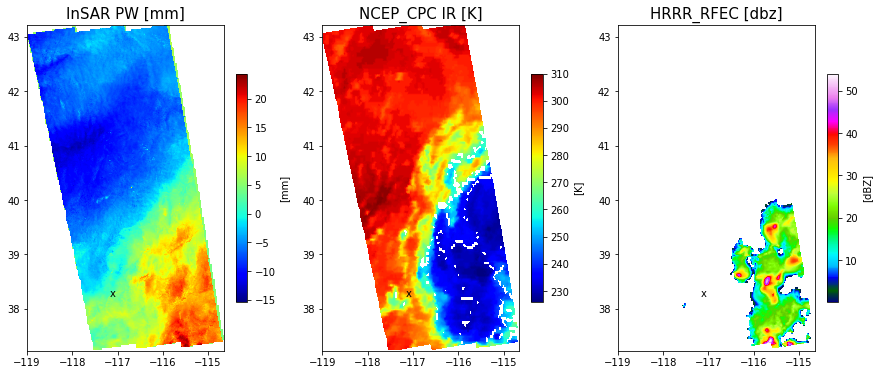

In [108]:
# assuming the reconstruct mean should be the same...
adjust_mean = np.nanmean(pwat_abs)-np.nanmean(pwat_re)

fig,ax = plt.subplots(1,3,figsize=(15,6))

cf1 = ax[0].pcolor(lon_sar,lat_sar,pwat_re,cmap='jet')
ax[0].text(lon_sar[idx],lat_sar[idy],'x',color='k')
cbar1 = plt.colorbar(cf1,ax=ax[0],shrink=0.7);cbar1.set_label('[mm]')

cf3 = ax[1].pcolor(lon_sar,lat_sar,BT_tmp*swath_mask,cmap='jet')
#ax[1].contour(lon_sar,lat_sar,topo_sar_mask,levels=['2000','2500']
#             ,colors=['brown','maroon'],linewidths=0.5,alpha=0.6)
ax[1].text(lon_sar[idx],lat_sar[idy],'x',color='k')
cbar3 = plt.colorbar(cf3,ax=ax[1],shrink=0.7);cbar3.set_label('[K]')

refc = tmp.refc.values
refc[refc<=0] = np.nan
cf4 = ax[2].pcolor(lon_sar,lat_sar,dbz_tmp*swath_mask,cmap='gist_ncar')
ax[2].set_ylim([axis_bound[0],axis_bound[1]]);ax[2].set_xlim([axis_bound[2],axis_bound[3]])
#ax[2].contour(lon_sar,lat_sar,topo_sar_mask,levels=['2000','2500']
#             ,colors=['brown','maroon'],linewidths=0.5,alpha=0.6)
ax[2].text(lon_sar[idx],lat_sar[idy],'x',color='k')
cbar4 = plt.colorbar(cf4,ax=ax[2],shrink=0.7);cbar4.set_label('[dBZ]')

ax[0].set_title('InSAR PW [mm]',fontsize=15)
ax[1].set_title('NCEP_CPC IR [K]',fontsize=15)
ax[2].set_title('HRRR_RFEC [dbz]',fontsize=15)

In [47]:
%%time
pwat_re = np.empty(disp.shape)
pwat_abs = np.copy(pwat_re)

for t in range(len(date_acqu)):
    sar_ps_diff = remap_hrrr2SAR(ps_diff[t,:,:]) # regrid pressure diff into sar grid
    sar_pwat_abs_ref = remap_hrrr2SAR(pwat_acqu[idx_ref,:,:].values)[idy,idx] # PW abs value at reference time and point
    sar_dry_delay = hydro_factor*sar_ps_diff*1000 #[mm]
    pwat_abs[t,:,:] = remap_hrrr2SAR(pwat_acqu[t,:,:].values)

    # reconstructing 2D-map
    pwat_re[t,:,:] = sar_pwat_abs_ref + (disp_zenith[t,:,:]-sar_dry_delay)/6.0

CPU times: user 3min 24s, sys: 2.09 s, total: 3min 26s
Wall time: 3min 26s


In [122]:
%%time
pwat_diff_mean = np.empty(len(date_acqu)) # deviation between pwat_reconstructed_InSAR and pwat_HRRR
pwat_diff_median = np.empty(len(date_acqu))
pwat_diff_upper_quartile = np.copy(pwat_diff_mean)
pwat_diff_lower_quartile = np.copy(pwat_diff_mean)

for t in range(len(date_acqu)):
    if np.sum(~np.isnan(pwat_re[t,:,:].ravel())) > 0:
        resi = (pwat_abs[t,:,:]-pwat_re[t,:,:]).ravel()
        resi = resi[~np.isnan(resi)]
    
        pwat_diff_mean[t] = np.mean(resi)
        pwat_diff_median[t] = np.median(resi)
        pwat_diff_upper_quartile[t] = np.percentile(resi, 75)
        pwat_diff_lower_quartile[t] = np.percentile(resi, 25)
    else:
        pwat_diff_mean[t] = np.nan
        pwat_diff_median[t] = np.nan
        pwat_diff_upper_quartile[t] = np.nan
        pwat_diff_lower_quartile[t] = np.nan

CPU times: user 7.05 s, sys: 2.01 ms, total: 7.05 s
Wall time: 7.05 s


Text(0, 0.5, 'PW$_{derived}$ - PW$_{HRRR}$ [mm]')

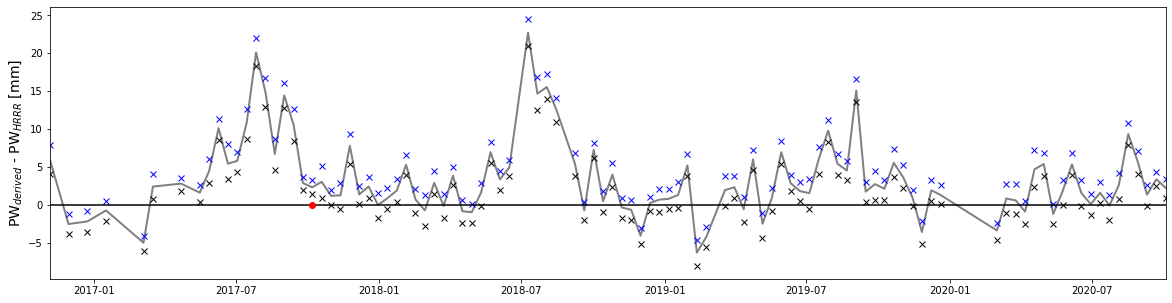

In [123]:
fig = plt.figure(figsize=(20,5))

plt.plot(date_acqu,pwat_diff_mean,'grey',linewidth=2)
plt.plot(date_acqu,pwat_diff_lower_quartile,'xk')
plt.plot(date_acqu,pwat_diff_upper_quartile,'xb')
plt.plot(date_acqu,np.zeros(len(date_acqu)),'k')
plt.plot(date_acqu[idx_ref],0,'or')
plt.xlim([date_acqu[15],date_acqu[-1]])
plt.ylabel('PW$_{derived}$ - PW$_{HRRR}$ [mm]',fontsize=14)

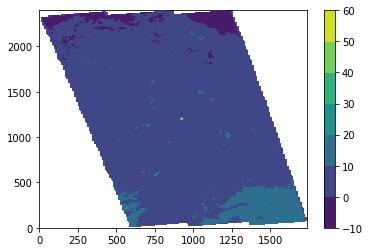

In [132]:
plt.contourf(pwat_re[100,:,:])
plt.colorbar()

Text(0, 0.5, 'PW$_{HRRR}$ [mm]')

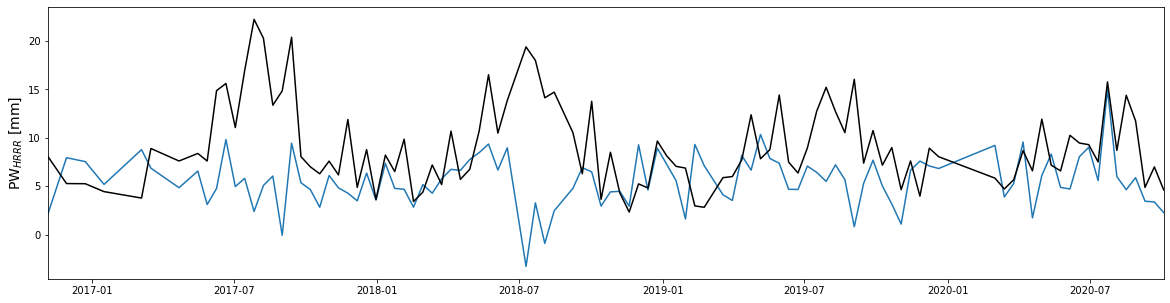

In [135]:
fig = plt.figure(figsize=(20,5))
plt.plot(date_acqu,np.nanmean(pwat_re,axis=(1,2)))
plt.plot(date_acqu,np.nanmean(pwat_abs,axis=(1,2)),'k') # HRRR
plt.xlim([date_acqu[15],date_acqu[-1]])
plt.ylabel('PW$_{HRRR}$ [mm]',fontsize=14)

In [56]:
pwat_diff_mean[100]

0.8059693766943931

In [57]:
pwat_diff_mean[100]

0.8059693766943931

In [ ]:
# %%time
# # # full figure output
# for t in range(85,len(date_ifgrams)):
    
#     fig,ax = plt.subplots(1,3,figsize=(13,4.5))
    
#     try:
#         a = disp_zenith_re[t,:,:]/6
#         clevels = np.linspace(-15,40,26)

#         cf1 = ax[0].contourf(lon_sar, lat_sar, disp_zenith_re[t,:,:]/6
#                              ,levels=clevels,cmap='gist_ncar_r',extend='both')
#         ax[0].set_title('InSAR_re \n Mean/6 [mm]:'+str(round(np.nanmean(disp_zenith_re[t,:,:]/6),2)))
#         cbar1 = plt.colorbar(cf1,ax=ax[0],shrink=0.8)
#         cbar1.cmap.set_under('darkred')
#         cbar1.cmap.set_over('darkblue')

#         cf2 = ax[1].contourf(pwat.longitude, pwat.latitude, pwat_diff[t,:,:],levels=clevels
#                             ,cmap='gist_ncar_r',extend='both')
#         ax[1].set_title('HRRR \n Mean [mm]:'+str(round(np.nanmean(pwat_diff[t,:,:]),2)));
#         ax[1].text(-118,44.1,str(date_acqu[t])[:10],fontsize=15,fontweight='bold')
#         cbar2 = plt.colorbar(cf2,ax=ax[1],shrink=0.8)
#         cbar2.cmap.set_under('darkred')
#         cbar2.cmap.set_over('darkblue')

#         # diff between HRRR and SAR
#         hrrr_pw = remap_hrrr2SAR(pwat_diff[t,:,:])
#         cf3 = ax[2].pcolor(lon_sar,lat_sar,disp_zenith_re[t,:,:]/6-hrrr_pw,vmin=-10,vmax=10
#                      ,cmap='gist_ncar_r')
#         ax[2].set_title('InSAR - HRRR \n offset [mm]: '+str(np.round(disp_offset[t],4)))
#         ax[2].contour(lon_sar,lat_sar,topo_sar_mask,levels=['2000'],colors=['k'],linewidths=0.5,alpha=0.6)

#         cbar3 = plt.colorbar(cf3,ax=ax[2],extend='both',shrink=0.8)
#         cbar3.set_label('[mm]',fontsize=12)
#         cbar3.cmap.set_under('darkred')
#         cbar3.cmap.set_over('darkblue')

#         fig.savefig(fig_dir+'HRRR_InSAR_CnstOffset_'+str(date_ifgrams[t])[2:-1],dpi=300,bbox_inches='tight')
#         plt.close()
#     except:
#         plt.close()

### checking topography and dry dely for data model

In [ ]:
t=58

fig,ax = plt.subplots(1,5,figsize=(20,6))
cf0 = ax[0].contourf(lon_sar, lat_sar, (disp_zenith[t,:,:])/6
                    ,cmap='jet')
plt.colorbar(cf0,ax=ax[0],shrink=0.7)
ax[0].set_title('InSAR \n Mean/6 [mm]:'+str(round(np.nanmean(disp_zenith[t,:,:]/6),2)))

cf2 = ax[2].contourf(pwat.longitude, pwat.latitude, pwat_diff[t,:,:],levels=21
                    ,cmap='jet')
cbar2 = plt.colorbar(cf2,ax=ax[2],shrink=0.7)
ax[2].set_title('HRRR \n Mean [mm]:'+str(round(np.nanmean(pwat_diff[t,:,:]),2)));
#vmin,vmax = cbar2.boundaries[0],cbar2.boundaries[-1]

cf1 = ax[1].contourf(lon_sar, lat_sar, (disp_zenith_re[t,:,:])/6
                     ,levels=np.linspace(cbar2.get_ticks()[0],cbar2.get_ticks()[-1],21),cmap='jet',extend='both')
cbar1 = plt.colorbar(cf1,ax=ax[1],shrink=0.7)
cbar1.set_ticks(cbar2.get_ticks())
cbar1.cmap.set_over('darkred')
cbar1.cmap.set_under('darkblue')
ax[1].set_title('InSAR_re \n Mean/6 [mm]:'+str(round(np.nanmean(disp_zenith_re[t,:,:]/6),2)))
ax[1].text(-118.4,44.1,str(date_acqu[t])[:10],fontsize=15,fontweight='bold')

# surface pressure
cf3 = ax[3].contourf(pwat.longitude, pwat.latitude, ps_diff[t,:,:]/100,levels=21
                    ,cmap='jet')
cbar3 = plt.colorbar(cf3,ax=ax[3],shrink=0.7)
ax[3].set_title('HRRR \n Mean [hpa]:'+str(round(np.nanmean(ps_diff[t,:,:]/100),2)))

# synthetic ps + pwat
cf4 = ax[4].contourf(pwat.longitude, pwat.latitude, 0.1*(ps_diff[t,:,:])/100+pwat_diff[t,:,:]
                     ,levels=np.linspace(cbar2.get_ticks()[0],cbar2.get_ticks()[-1],21),cmap='jet',extend='both')
cbar4 = plt.colorbar(cf4,ax=ax[4],shrink=0.7)
cbar4.set_ticks(cbar2.get_ticks())
cbar4.cmap.set_over('darkred')
cbar4.cmap.set_under('darkblue')

## add topography 
ax[0].contour(lon_sar,lat_sar,topo_sar_mask,levels=[2000,3000,4000]
              ,colors=['k'],linewidths=0.5,alpha=0.8)

In [ ]:
# check factor 6 relation 
t=58

fig,ax = plt.subplots(1,4,figsize=(14,6))
cf0 = ax[0].contourf(lon_sar, lat_sar, (disp_zenith[t,:,:]-disp_zenith[t+1,:,:])/6
                    ,cmap='jet')
plt.colorbar(cf0,ax=ax[0],shrink=0.7)
ax[0].set_title('InSAR \n Mean/6 [mm]:'+str(round(np.nanmean(disp_zenith[t,:,:]/6),2)))

cf2 = ax[2].contourf(pwat.longitude, pwat.latitude, pwat_diff[t,:,:]-pwat_diff[t+1,:,:],levels=21
                    ,cmap='jet')
cbar2 = plt.colorbar(cf2,ax=ax[2],shrink=0.7)
ax[2].set_title('HRRR \n Mean [mm]:'+str(round(np.nanmean(pwat_diff[t,:,:]),2)));
#vmin,vmax = cbar2.boundaries[0],cbar2.boundaries[-1]

cf1 = ax[1].contourf(lon_sar, lat_sar, (disp_zenith_re[t,:,:]-disp_zenith_re[t+1,:,:])/6
                     ,levels=np.linspace(cbar2.get_ticks()[0],cbar2.get_ticks()[-1],21),cmap='jet',extend='both')
cbar1 = plt.colorbar(cf1,ax=ax[1],shrink=0.7)
cbar1.set_ticks(cbar2.get_ticks())
cbar1.cmap.set_over('darkred')
cbar1.cmap.set_under('darkblue')
ax[1].set_title('InSAR_re \n Mean/6 [mm]:'+str(round(np.nanmean(disp_zenith_re[t,:,:]/6),2)))
ax[1].text(-118.4,44.1,str(date_acqu[t])[:10],fontsize=15,fontweight='bold')

# surface pressure
cf3 = ax[3].contourf(pwat.longitude, pwat.latitude, (ps_diff[t,:,:]-ps_diff[t+1,:,:])/100,levels=21
                    ,cmap='jet')
cbar3 = plt.colorbar(cf3,ax=ax[3],shrink=0.7)
ax[3].set_title('HRRR \n Mean [hpa]:'+str(round(np.nanmean(-ps_diff[t,:,:]/100),2)))

### Building linear model 

In [ ]:
hydro_factor = 1e-6*0.776*287.15/9.8 # [m/pa]

In [ ]:
t=58

disp_raw = disp_zenith[t,:,:]-disp_zenith[idx_ref,:,:] # true zenith row data [mm]
hrrr_pw = remap_hrrr2SAR(pwat_diff[t,:,:]-pwat_diff[idx_ref,:,:]) # [mm]
hrrr_ps = remap_hrrr2SAR(ps_diff[t,:,:]-ps_diff[idx_ref,:,:]) # [pa]

# remove nan grids for both datasets
idx_rmnan_sar = np.where(np.isnan(disp_raw.ravel())==0)[0]
idx_rmnan_hrrr = np.where(np.isnan(hrrr_pw.ravel())==0)[0]
idx_com = np.intersect1d(idx_rmnan_sar,idx_rmnan_hrrr)

disp_raw1 = disp_raw.ravel()[idx_com]
hrrr_pw1 = hrrr_pw.ravel()[idx_com]
hrrr_ps1 = hrrr_ps.ravel()[idx_com]
topo_1 = topo_sar_mask.ravel()[idx_com]
topo_trap = topo_1*hrrr_pw1

# Total zenith delay removed hydrostatic delay
y = disp_raw1 - hydro_factor*hrrr_ps1*100*10

# buulding predictors
x_predictor = []
for n in range(len(y)):
    x_predictor.append([hrrr_pw1[n],topo_1[n],topo_trap[n]])

reg = LinearRegression().fit(x_predictor, y)

In [ ]:
type(reg.score(x_predictor,y))

In [ ]:
np.round(reg.coef_,5)

In [ ]:
reg.intercept_

In [ ]:
a = disp_raw-hydro_factor*hrrr_ps
clevels = np.linspace(np.min(a[~np.isnan(a)]),np.max(a[~np.isnan(a)]),21)

disp_predict = reg.coef_[0]*hrrr_pw + reg.coef_[1]*topo_sar_mask \
                + reg.coef_[2]*topo_sar_mask*hrrr_pw + reg.intercept_

fig,ax = plt.subplots(1,4,figsize=(15,5))

cf1 = ax[0].contourf(lon_sar,lat_sar,disp_raw,cmap='gist_ncar_r'
                     ,levels=clevels,extend='both')

cf2 = ax[1].contourf(lon_sar,lat_sar,disp_raw-hydro_factor*hrrr_ps,cmap='gist_ncar_r'
                     ,levels=clevels,extend='both')
cf3 = ax[2].contourf(lon_sar,lat_sar,disp_predict,
              cmap='gist_ncar_r',levels=clevels,
              extend='both')
cbar1 = plt.colorbar(cf1,ax=ax[0],shrink=0.8,pad=0.02)
cbar1.cmap.set_under('darkred')
cbar1.cmap.set_over('darkblue')
cbar2 = plt.colorbar(cf2,ax=ax[1],shrink=0.8,pad=0.02)
cbar2.cmap.set_under('darkred')
cbar2.cmap.set_over('darkblue')
cbar3 = plt.colorbar(cf3,ax=ax[2],shrink=0.8,pad=0.02)
cbar3.cmap.set_under('darkred')
cbar3.cmap.set_over('darkblue')

cf4 = ax[3].contourf(lon_sar,lat_sar,disp_raw-disp_predict,cmap='gist_ncar_r'
                     ,levels=np.linspace(-50,50,21),extend='both')
ax[3].contour(lon_sar,lat_sar,topo_sar_mask,levels=[2000]
                     ,colors=['black'],linewidths=0.5,alpha=0.6)
cbar4 = plt.colorbar(cf4,ax=ax[3],shrink=0.8,pad=0.02)
cbar4.cmap.set_under('darkred')
cbar4.cmap.set_over('darkblue')

ax[0].set_title('SAR, total delay')
ax[1].set_title('SAR, RM Dry_delay')
ax[2].set_title('SAR$_{predicted}$ \n L=aL$_{pw}$+bL$_{topo}$+cL$_{topo*pw}$')
ax[3].set_title('SAR-SAR$_{predicted}$')

# mark refernce point
idx = find_nearest(lon_sar,-117.338974)
idy = find_nearest(lat_sar,39.593674)
ax[0].text(lon_sar[idx],lat_sar[idy],'x',color='k')

ax[0].text(-118.4,44,str(date_acqu[t])[:10],fontsize=15,fontweight='bold')
ax[1].text(-118,44,'Coef: '+str(np.round(reg.coef_,5))+'\n'+'Residual [mm]: '+str(np.round(reg.intercept_,4)) \
          +'\n'+'R$^2$: '+str(np.round(reg.score(x_predictor,y),3)),fontsize=12)

#fig.savefig(fig_dir+'demo.png',dpi=300,bbox_inches='tight')

In [ ]:
r2_value = np.zeros(len(date_ifgrams))*np.nan
coef_com = np.zeros((len(date_ifgrams),4))*np.nan

for t in range(len(date_ifgrams)):
    print(date_ifgrams[t])
    fig,ax = plt.subplots(1,4,figsize=(15,5))
    
    try:
        disp_raw = disp_zenith[t,:,:]-disp_zenith[idx_ref,:,:] # true zenith row data
        hrrr_pw = remap_hrrr2SAR(pwat_diff[t,:,:]-pwat_diff[idx_ref,:,:])
        hrrr_ps = remap_hrrr2SAR(ps_diff[t,:,:]-ps_diff[idx_ref,:,:])

        # remove nan grids for both datasets
        idx_rmnan_sar = np.where(np.isnan(disp_raw.ravel())==0)[0]
        idx_rmnan_hrrr = np.where(np.isnan(hrrr_pw.ravel())==0)[0]
        idx_com = np.intersect1d(idx_rmnan_sar,idx_rmnan_hrrr)

        disp_raw1 = disp_raw.ravel()[idx_com]
        hrrr_pw1 = hrrr_pw.ravel()[idx_com]
        hrrr_ps1 = hrrr_ps.ravel()[idx_com]
        topo_1 = topo_sar_mask.ravel()[idx_com]
        topo_trap = topo_1*hrrr_pw1

        # Total zenith delay removed hydrostatic delay
        y = disp_raw1 - hydro_factor*hrrr_ps1*100*10

        # buulding predictors
        x_predictor = []
        for n in range(len(y)):
            x_predictor.append([hrrr_pw1[n],topo_1[n],topo_trap[n]])

        reg = LinearRegression().fit(x_predictor, y)

        r2_value[t] = reg.score(x_predictor,disp_raw1)
        coef_com[t,:3] = reg.coef_
        coef_com[t,3] = reg.intercept_

        # plotting section
        a = disp_raw-hydro_factor*hrrr_ps
        clevels = np.linspace(np.min(a[~np.isnan(a)]),np.max(a[~np.isnan(a)]),21)

        disp_predict = reg.coef_[0]*hrrr_pw + reg.coef_[1]*topo_sar_mask \
                        + reg.coef_[2]*topo_sar_mask*hrrr_pw + reg.intercept_

        fig,ax = plt.subplots(1,4,figsize=(15,5))

        cf1 = ax[0].contourf(lon_sar,lat_sar,disp_raw,cmap='gist_ncar_r'
                             ,levels=clevels,extend='both')

        cf2 = ax[1].contourf(lon_sar,lat_sar,disp_raw-hydro_factor*hrrr_ps,cmap='gist_ncar_r'
                             ,levels=clevels,extend='both')
        cf3 = ax[2].contourf(lon_sar,lat_sar,disp_predict,
                      cmap='gist_ncar_r',levels=clevels,
                      extend='both')
        cbar1 = plt.colorbar(cf1,ax=ax[0],shrink=0.8,pad=0.02)
        cbar1.cmap.set_under('darkred')
        cbar1.cmap.set_over('darkblue')
        cbar2 = plt.colorbar(cf2,ax=ax[1],shrink=0.8,pad=0.02)
        cbar2.cmap.set_under('darkred')
        cbar2.cmap.set_over('darkblue')
        cbar3 = plt.colorbar(cf3,ax=ax[2],shrink=0.8,pad=0.02)
        cbar3.cmap.set_under('darkred')
        cbar3.cmap.set_over('darkblue')

        cf4 = ax[3].contourf(lon_sar,lat_sar,disp_raw-disp_predict,cmap='gist_ncar_r'
                             ,levels=np.linspace(-50,50,21),extend='both')
        ax[3].contour(lon_sar,lat_sar,topo_sar_mask,levels=[2000]
                             ,colors=['black'],linewidths=0.5,alpha=0.6)
        cbar4 = plt.colorbar(cf4,ax=ax[3],shrink=0.8,pad=0.02)
        cbar4.cmap.set_under('darkred')
        cbar4.cmap.set_over('darkblue')

        ax[0].set_title('SAR, total delay')
        ax[1].set_title('SAR, RM Dry_delay')
        ax[2].set_title('SAR$_{predicted}$ \n L=aL$_{pw}$+bL$_{topo}$+cL$_{topo*pw}$')
        ax[3].set_title('SAR-SAR$_{predicted}$')

        # mark refernce point
        idx = find_nearest(lon_sar,-117.338974)
        idy = find_nearest(lat_sar,39.593674)
        ax[0].text(lon_sar[idx],lat_sar[idy],'x',color='k')

        ax[0].text(-118.4,44,str(date_acqu[t])[:10],fontsize=15,fontweight='bold')
        ax[1].text(-118,44,'Coef: '+str(np.round(reg.coef_,5))+'\n'+'Residual [mm]: '+str(np.round(reg.intercept_,4)) \
                  +'\n'+'R$^2$: '+str(np.round(reg.score(x_predictor,y),3)),fontsize=12)

        # save figure
        fig.savefig(fig_dir+'HRRR_InSAR_rebuilt_'+str(date_ifgrams[t])[2:-1],dpi=300,bbox_inches='tight')
        plt.close()
    
    except:
        plt.close()

In [ ]:
## plotting coefficient and residual 
fig, ax = plt.subplots(5,1,figsize=(10,10))
coef = ['a','b','c','residual']
for n in range(4):
    ax[n].plot(date_acqu,coef_com[:,n])
    ax[n].set_xlim([date_acqu[0],date_acqu[-1]])
    ax[n].set_ylabel(coef[n],fontsize=12)
ax[4].plot(date_acqu,r2_value)
ax[4].plot(date_acqu[idx_ref],r2_value[idx_ref],'or')
ax[4].set_xlim([date_acqu[0],date_acqu[-1]])
ax[4].set_ylabel('R$^2$',fontsize=12)
ax[0].plot(date_acqu,np.ones(len(date_ifgrams))*6)
ax[0].set_title('SAR$_{predicted}$ \n L=a*L$_{pw}$+b*L$_{topo}$+c*L$_{topo*pw}$+residual',fontsize=15)

In [ ]:
cbar1.values.shape[0]

In [ ]:
# %%time
# # extract corresponding pwat 
# y1 = np.array([axis_bound[0],43])
# x1 = np.array([-117.5,axis_bound[2]])
# y2 = np.array([37.5,axis_bound[1]])
# x2 = np.array([axis_bound[3],-115.85])

# # formula 1 & 2 for approximate swath
# slp1 = (y1[0]-y1[1])/(x1[0]-x1[1]); b1 = y1[0]-slp1*x1[0]
# slp2 = (y2[0]-y2[1])/(x2[0]-x2[1]); b2 = y2[0]-slp2*x2[0]

# # 1-d array
# pp = pwat_acqu[-1,:,:].values.ravel()
# lon_test,lat_test = np.meshgrid(pwat.longitude,pwat.latitude)
# lon_test = lon_test.ravel(); lat_test = lat_test.ravel()
# idx = np.where(np.logical_and(lat_test-slp1*lon_test-b1 > 0, lat_test-slp2*lon_test-b2<0))
# test2 = pp[idx]

# # plotting pwat_diff timeseries
# fig,ax = plt.subplots(rows+1,21,figsize=(45,15))
# for t in range(len(col)):
#     try:
#         pp = (pwat_acqu[idx_ref,:,:]-pwat_acqu[t,:,:]).values.ravel()
#         lon_tmp,lat_tmp = np.meshgrid(pwat.longitude,pwat.latitude)
#         lon_tmp = lon_test.ravel(); lat_test = lat_test.ravel()
#         idx = np.where(np.logical_and(lat_test-slp1*lon_test-b1 > 0, lat_test-slp2*lon_test-b2<0))
#         test2 = pp[idx]
        
#         sig_hrrr = (test2-np.nanmean(test2))/np.nanmean(test2) # normalized values
#         sig_sar = (disp[t,:,:]-np.nanmean(disp[t,:,:]))/np.nanmean(disp[t,:,:])
#         ax[row[t],col[t]].hist(sig_hrrr,bins=21,histtype='step',color='r'
#                                ,density=True,linewidth=2)
#         ax[row[t],col[t]].hist(sig_sar.ravel(),bins=21,histtype='step',color='k'
#                                ,density=True,linewidth=2)
#         ax[row[t],col[t]].set_ylim([0,1])
#         ax[row[t],col[t]].vlines(0,ymin=0,ymax=1,linewidth=1,linestyle=':',color='grey')
#         ax[row[t],col[t]].set_ylim([0, 1])
#         #ax[row[t],col[t]].set_xlim(-3, 3)
#         ax[row[t],col[t]].set_title(str(date_ifgrams[t])[2:-1],fontsize=14)
#         ax[row[t],col[t]].spines['top'].set_color('w') 
#         ax[row[t],col[t]].spines['right'].set_color('w')
    
#     except:
#         ax[row[t],col[t]].set_xticks([]);ax[row[t],col[t]].set_yticks([])
#         ax[row[t],col[t]].spines['bottom'].set_color('w')
#         ax[row[t],col[t]].spines['top'].set_color('w') 
#         ax[row[t],col[t]].spines['right'].set_color('w')
#         ax[row[t],col[t]].spines['left'].set_color('w')
        
# plt.tight_layout()
# fig.patch.set_facecolor('white')

In [ ]:
#fig.savefig('NormalizedPDF_timeseries.png',bbox_inches='tight',dpi=300)

#### Remapping InSAR, Spatial correlation

In [ ]:
## interpolating sar into hrrr grid

lon_hrrr,lat_hrrr = np.meshgrid(pwat.longitude.values,pwat.latitude.values)
lon_isar,lat_isar = np.meshgrid(lon_sar,lat_sar)
points = np.stack([lon_isar.ravel(),lat_isar.ravel()]).swapaxes(0,1)
disp_remap = griddata(points, disp[-1,:,:].ravel(), (lon_hrrr, lat_hrrr), method='nearest')

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,6))
ax[0].contourf(pwat.longitude,pwat.latitude,pwat_acqu[idx_ref,:,:]-pwat_acqu[-1,:,:])
ax[1].contourf(pwat.longitude,pwat.latitude,disp_remap)
ax[0].set_title('HRRR'+'\n'+'test')

In [ ]:
pw_diff = (pwat_acqu[idx_ref,:,:]-pwat_acqu[-1,:,:]).values.ravel()
idx_valid = np.where(np.isnan(disp_remap.ravel())==0)

slp,intp,r_val,p_val,std = linregress(pw_diff[idx_valid],100*disp_remap.ravel()[idx_valid])

In [ ]:
pw_diff = (pwat_acqu[idx_ref,:,:]-pwat_acqu[-1,:,:]).values.ravel()
idx_valid = np.where(np.isnan(disp_remap.ravel())==0)
pw_diff = pw_diff[idx_valid]
disp_diff = 100*disp_remap.ravel()[idx_valid]

slp,intp,r_val,p_val,std = linregress(pw_diff,disp_diff)
plt.scatter(pw_diff,disp_diff,edgecolor='w')
xmin = pw_diff.min();
xmax = pw_diff.max();
xline = np.linspace(xmin-0.5,xmax+0.5,10)
plt.plot(xline,xline*slp+intp,zorder=1,color='k')
plt.xlabel('PW_diff [mm]');plt.ylabel('disp [cm]')

In [ ]:
%%time

lon_hrrr,lat_hrrr = np.meshgrid(pwat.longitude.values,pwat.latitude.values)
lon_isar,lat_isar = np.meshgrid(lon_sar,lat_sar)
points = np.stack([lon_isar.ravel(),lat_isar.ravel()]).swapaxes(0,1)

# plotting pwat_diff timeseries
fig,ax = plt.subplots(rows+1,21,figsize=(45,15))
for t in range(len(col)):
    try:
        disp_remap = griddata(points, disp[t,:,:].ravel(), (lon_hrrr, lat_hrrr), method='nearest')
        pw_diff = (pwat_acqu[idx_ref,:,:]-pwat_acqu[t,:,:]).values.ravel()
        idx_valid = np.where(np.isnan(disp_remap.ravel())==0)
        pw_diff = pw_diff[idx_valid]
        disp_diff = 100*disp_remap.ravel()[idx_valid]

        slp,intp,r_val,p_val,std = linregress(pw_diff,disp_diff)
        ax[row[t],col[t]].scatter(pw_diff,disp_diff,edgecolor='None')
        xmin = pw_diff.min();
        xmax = pw_diff.max();
        xline = np.linspace(xmin-0.5,xmax+0.5,10)
        ax[row[t],col[t]].plot(xline,xline*slp+intp,zorder=1,color='k')
        #ax[row[t],col[t]].set_xlabel('PW_diff [mm]',fontsize=12)
        #ax[row[t],col[t]].set.ylabel('disp [cm]',fontsize=12)
        ax[row[t],col[t]].set_title(str(date_ifgrams[t])[2:-1]+'\n'+'slp: '+str(round(slp,2))+'(cm/mm) ,R: '+str(round(r_val,2))
                                    ,fontsize=12)
        ax[row[t],col[t]].spines['top'].set_color('w') 
        ax[row[t],col[t]].spines['right'].set_color('w')
    
    except:
        ax[row[t],col[t]].set_xticks([]);ax[row[t],col[t]].set_yticks([])
        ax[row[t],col[t]].spines['bottom'].set_color('w')
        ax[row[t],col[t]].spines['top'].set_color('w') 
        ax[row[t],col[t]].spines['right'].set_color('w')
        ax[row[t],col[t]].spines['left'].set_color('w')
        
plt.tight_layout()
fig.patch.set_facecolor('white')

In [ ]:
fig.savefig('spatialcorrelation_timeseries.png',bbox_inches='tight',dpi=300)

### correlation ranked by seasons, seeking for potential biases? 